### Prepare storage and get Data

In [0]:
!wget -O data.zip http://hck.re/TT3Xkb

--2019-09-29 14:10:11--  http://hck.re/TT3Xkb
Resolving hck.re (hck.re)... 54.169.54.236, 52.220.222.195, 13.250.79.191
Connecting to hck.re (hck.re)|54.169.54.236|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Cookie coming from hck.re attempted to set domain to hackerearth.com
Cookie coming from hck.re attempted to set domain to hackerearth.com
Cookie coming from hck.re attempted to set domain to hackerearth.com
Location: https://he-s3.s3.amazonaws.com/media/hackathon/hdfc-bank-ml-hiring-challenge-2019/banking-behavioral-scorecard-for-internal-liability-customers-4caf1786/d407ebe0db9a11e9.zip [following]
--2019-09-29 14:10:12--  https://he-s3.s3.amazonaws.com/media/hackathon/hdfc-bank-ml-hiring-challenge-2019/banking-behavioral-scorecard-for-internal-liability-customers-4caf1786/d407ebe0db9a11e9.zip
Resolving he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)... 52.219.40.188
Connecting to he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)|52.219.40.188|:44

In [0]:
!unzip data.zip

Archive:  data.zip
   creating: DataSet/
  inflating: DataSet/Train.csv       
  inflating: DataSet/Sample_submission.csv  
  inflating: DataSet/Test.csv        


### Remove Useless features found in EDA and feature selection

In [0]:
import pickle
with open('useless_features', 'rb') as f:
    useless_features = pickle.load(f)

print(f"Number of removable features are {len(useless_features)}")

Number of removable features are 1719


###Import Libraries

In [0]:
import pandas as pd
from pathlib import Path
DATA_PATH = Path('DataSet')

### Read and filter data

In [0]:
train_data = pd.read_csv(DATA_PATH/'Train.csv', )
print(f"{train_data.shape} features in dataset before filtering")
train_data_filt = train_data[train_data.columns.difference(useless_features)]
print(f"{train_data_filt.shape} features in dataset before filtering")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (746,835) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(17521, 2395) features in dataset before filtering
(17521, 686) features in dataset before filtering


### Check column data types

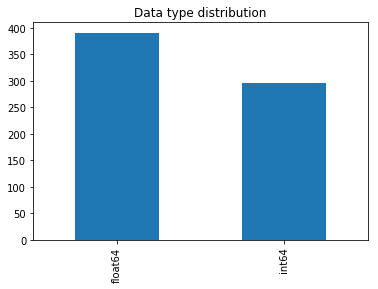

In [0]:
train_data_filt.dtypes.value_counts().plot.bar(title='Data type distribution')

In [0]:
train_data_filt.describe()

,Col10,Col100,Col1000,Col1002,Col1003,Col1008,Col1009,Col101,Col102,Col1020,Col1021,Col1024,Col1025,Col1026,Col1028,Col1029,Col103,Col1030,Col1031,Col1036,Col104,Col1044,Col1048,Col1049,Col105,Col1050,Col1051,Col1054,Col106,Col1068,Col107,Col1070,Col1072,Col1073,Col1093,Col1095,Col11,Col1116,Col1118,Col1119,...,Col931,Col933,Col934,Col935,Col936,Col937,Col938,Col939,Col94,Col942,Col943,Col944,Col95,Col950,Col951,Col952,Col953,Col954,Col956,Col957,Col958,Col959,Col96,Col964,Col97,Col970,Col971,Col976,Col977,Col98,Col980,Col981,Col982,Col983,Col986,Col99,Col996,Col997,Col998,Col999
count,1.752100e+04,11539.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,11842.000000,10470.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,9990.000000,17521.000000,17521.000000,17521.000000,9509.000000,17521.000000,17521.000000,17521.000000,7803.000000,17521.000000,17521.000000,17521.000000,16099.000000,17521.000000,15637.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,1.752100e+04,17521.000000,17521.000000,17521.000000,...,16275.000000,16170.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,14079.000000,17521.000000,17521.000000,17521.000000,11221.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,13274.000000,17521.000000,8165.000000,17521.000000,17521.000000,17521.000000,17521.000000,12405.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,4488.000000,17521.000000,17521.000000,17521.000000,17521.000000
mean,2.971069e+04,1.309386,1.939273,1.912505,1.242452,1.253011,0.926317,1.149046,1.460267,2.003196,1.418241,2.052337,1.460647,2.278865,2.239826,1.441927,1.283183,1.266138,1.237829,0.935734,1.547586,1.281605,1.274528,1.243080,1.417404,1.219565,1.110553,1.265909,1.437693,1.175618,2.090463,1.319731,1.349409,1.257862,1.241539,1.146681,3.617392e+04,1.966212,2.035101,1.045431,...,0.358401,0.352756,2.366931,1.476571,2.454769,1.667941,1.355060,1.342218,1.375453,1.297871,1.271046,0.986702,1.059977,0.311169,0.316649,1.377604,1.498031,1.366931,1.481023,1.476457,1.420638,1.338223,1.659861,1.040352,1.296754,1.324239,1.127961,1.428457,1.520119,1.864248,1.551053,1.490840,1.738029,1.117573,1.616346,1.479501,1.830432,1.241653,1.704412,1.134068
std,2.981508e+05,1.347284,1.225849,1.306265,0.992497,1.269177,1.000738,1.190422,1.414652,1.254940,1.032108,1.263986,1.047696,1.134038,1.120488,1.008219,1.256871,1.068007,1.045046,1.039671,1.459224,1.037058,1.021334,1.004605,1.307870,1.068657,1.007190,1.092318,9.918549,1.023263,17.141681,1.094164,1.068459,1.028392,0.957362,0.953096,2.612427e+05,1.214496,1.051402,0.881437,...,0.262387,0.276509,1.173139,0.985472,1.184335,1.040835,1.121657,1.108345,1.404166,1.114619,1.119967,1.092939,1.109698,0.663183,0.659460,1.090321,1.132293,1.124905,1.113685,1.107327,1.159286,1.099338,1.507841,1.137280,1.222841,1.134429,1.011213,1.113496,1.141355,1.569506,1.146679,1.114065,1.202299,0.936689,1.230164,1.322864,1.174190,0.952611,1.232507,0.977664
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-154.244141,0.000000,-210.023233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.787456e+03,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,

There seems to be need to scale the data in order to perform better modeling with **non-tree** type classifiers. So let's try modeling with Decision tree classifier

### Impute missing data

In [0]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

X = train_data_filt.drop(['Col2'], axis=1).values
y = train_data_filt.Col2.values

imp = IterativeImputer(max_iter=20, random_state=0, verbose=2)

X_imp = imp.fit_transform(X, y)

[IterativeImputer] Completing matrix with shape (17521, 685)
[IterativeImputer] Ending imputation round 1/20, elapsed time 1472.67
[IterativeImputer] Early stopping criterion reached.


### Perform Model building and Cross validation

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree.export import export_text
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.scorer import make_scorer

decision_tree = DecisionTreeClassifier(random_state=0, max_depth=10)

# weighted f1_score
wgted_f1 = make_scorer(f1_score, average='weighted')
# Stratified split since we have class imbalance
skf = StratifiedKFold(n_splits=5)
scoring = dict(weighted_f1 = wgted_f1)

scores = cross_validate(decision_tree, X_imp, y, scoring=scoring,
                        cv=skf.split(X_imp, y), return_estimator=True,
                        n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished


In [0]:
sorted(scores.keys())

['estimator', 'fit_time', 'score_time', 'test_weighted_f1']

In [0]:
scores['test_weighted_f1']

array([0.85688656, 0.86460008, 0.85557827, 0.85318739, 0.86000416])

### Persist model objects

In [0]:
import joblib

joblib.dump(imp, 'IterativeImputer.impute')

['IterativeImputer.impute']

### Transform test data

In [0]:
_ = pd.read_csv(DATA_PATH/'Test.csv')
test_data = _[_.columns.difference(useless_features)]

test_data_imp = imp.transform(test_data)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (700,731,740,752,761,789,811,820,829,841,850) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[IterativeImputer] Completing matrix with shape (20442, 685)
[IterativeImputer] Ending imputation round 1/1, elapsed time 17.69


### Predict with test data

In [0]:
predictions = {}
for i, estimator in enumerate(scores['estimator']):
    est_name = f'Decision_tree_model_{i}'
    joblib.dump(estimator, est_name+'.model')
    predictions[f'Decision_tree_model_{i}'] = estimator.predict(test_data_imp)

In [0]:
test_ids = pd.read_csv(DATA_PATH/'Test.csv', usecols=['Col1'])

In [0]:
for prediction in predictions:
    t_df = test_ids.copy()
    t_df['Col2'] = predictions[prediction].reshape(-1,1)
    t_df.to_csv(f"{prediction}.csv", index=False)

### Save Imputer to drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir drive/My\ Drive/HDFC_ML

In [0]:
!mv /content/IterativeImputer.impute drive/My\ Drive/HDFC_ML

### Save Model Representation

In [0]:
from sklearn.externals.six import StringIO
import pydot
from sklearn import tree

dot_data = StringIO()
col_names = train_data_filt.drop(['Col2'], axis=1).columns.tolist()

In [0]:
i = 0
for estimator in scores['estimator']:
    tree.export_graphviz(estimator,
        out_file=dot_data,
        max_depth=4,
        feature_names=col_names,
        class_names=['0', '1'],
        filled=True,
        rounded=True,
        impurity=False)

    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    graph[0].write_pdf(f"model_{i}.pdf")
    i+=1